
# Introduction to the SpatioTemporal Asset Catalog (STAC)
### [This notebook is modified from here](https://github.com/brazil-data-cube/code-gallery/blob/master/jupyter/Python/stac/stac-introduction.ipynb)
Original notebook authored by 
<br/>
Matheus Zaglia, Rennan Marujo, Gilberto R. Queiroz, Felipe Menino Carlos 
<br/>Earth Observation and Geoinformatics Division, National Institute for Space Research (INPE)
Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
<br/>


# Introduction
## to add - stackstac explanation and how it works with pystac.

The [**S**patio**T**emporal **A**sset **C**atalog (STAC)](https://stacspec.org/) is a specification created through the colaboration of several organizations intended to increase satellite image search interoperability.

<center>
<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-concept.png" width="480" />
<br/>
<b>Figure 1</b> - STAC model.
</center>

The description of the concepts below are adapted from the [STAC Specification](https://github.com/radiantearth/stac-spec):

- **Item**: a `STAC Item` is the atomic unit of metadata in STAC, providing links to the actual `assets` (including thumbnails) that they represent. It is a `GeoJSON Feature` with additional fields for things like time, links to related entities and mainly to the assets. According to the specification, this is the atomic unit that describes the data to be discovered in a `STAC Catalog` or `Collection`.

- **Asset**: a `spatiotemporal asset` is any file that represents information about the earth captured in a certain space and time.


- **Catalog**: provides a structure to link various `STAC Items` together or even to other `STAC Catalogs` or `Collections`.


- **Collection:** is a specialization of the `Catalog` that allows additional information about a spatio-temporal collection of data.

# STAC Client API

For running the examples in this Jupyter Notebook you will need to install the [pystac-client](https://pystac-client.readthedocs.io/en/latest/).

PySTAC-Client (pystac-client) is an extension of the PySTAC library. It adds support for STAC APIs and static STAC catalogs. You can use PySTAC-Client with both static catalogs and dynamic catalogs that use APIs. Its main purpose is to support STAC API endpoints like search. 

We will use the Sentinel-2 Level 2A collection for this notebook.

You can interact with the [Sentinel-2 Level 2A catalog here](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a)

In [1]:
# !pip install pystac-client==0.3.2
# !pip install rasterio shapely matplotlib tqdm

In [2]:
import numpy
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio import plot
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import pystac_client

In [3]:
service = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

# Listing the Available Data Products
Element 84 maintain several STAC collections for different satellite services:

In [4]:
for collection in service.get_collections():
    print(collection)

<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-1-grd>
<CollectionClient id=sentinel-2-c1-l2a>


<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-catalog.png?raw=true" align="right" width="300"/>

# Retrieving the Metadata of a Collection

The `collection` method returns information about a given image or data cube collection identified by its name. In this example we are retrieving information about the datacube collection `CB4-16D-2`:

In [5]:
collection = service.get_collection('sentinel-2-l2a')
collection

<CollectionClient id=sentinel-2-l2a>

<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-item.png?raw=true" align="right" width="300"/>

# Retrieving Items


Add filtering criteria to narrow down to images that match location, daterange, cloud cover etc.
 - area can be specified using `bbox` or `intersects`. `intersects` can be a point or polygon.
 - `datatime` to filter within a range or for a specific date
 - `collections` can be specified in the search if it has not already been specified
 - other collection specific metadata like cloud cover
 - to limit results, use `max_items`

The method `.search(**kwargs)` returns a `ItemSearch` representation which has handy methods to identify the matched results. For example, to check the number of items matched, use `.matched()`:

In [6]:
item_search = service.search(bbox=(145.8, -37.3, 146.0, -37.1),
                             datetime='2023-01-01/2023-01-30',
                             collections=['sentinel-2-l2a'],
                             max_items = 10)

print(f"Total number of matching items: {item_search.matched()}")

Total number of matching items: 40


To iterate over the matched result, use `.get_items()` to traverse the list of items. If a `max_items` limit was applied in the previous step, only that number of items will be printed.

In [7]:
for item in item_search.get_items():
    print(item)

/opt/conda/lib/python3.11/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


<Item id=S2A_55HCU_20230130_0_L2A>
<Item id=S2A_55HDU_20230130_0_L2A>
<Item id=S2A_55HCV_20230130_0_L2A>
<Item id=S2A_55HDV_20230130_0_L2A>
<Item id=S2A_55HDU_20230127_0_L2A>
<Item id=S2A_55HCV_20230127_0_L2A>
<Item id=S2B_55HCU_20230125_0_L2A>
<Item id=S2B_55HDU_20230125_0_L2A>
<Item id=S2B_55HCV_20230125_0_L2A>
<Item id=S2B_55HDV_20230125_0_L2A>


<img src="https://raw.githubusercontent.com/brazil-data-cube/code-gallery/master/img/stac/stac-asset.png?raw=true" align="right" width="300"/>

# Assets

The assets with the links to the images, thumbnails or specific metadata files, can be accessed through the property `assets` (from a given item):

In [8]:
assets = item.assets
for k in assets.keys():
    print(k)

aot
blue
coastal
granule_metadata
green
nir
nir08
nir09
red
rededge1
rededge2
rededge3
scl
swir16
swir22
thumbnail
tileinfo_metadata
visual
wvp
aot-jp2
blue-jp2
coastal-jp2
green-jp2
nir-jp2
nir08-jp2
nir09-jp2
red-jp2
rededge1-jp2
rededge2-jp2
rededge3-jp2
scl-jp2
swir16-jp2
swir22-jp2
visual-jp2
wvp-jp2


The metadata related to the Sentinel-2 blue band is available under the dictionary key `blue`.

[You can explore the Sentinel-2 STAC and see metadata here](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/collections/sentinel-2-l2a)

In [9]:
blue_asset = assets['blue']
blue_asset

<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B02.tif>

To iterate in the item's assets, use the following pattern:

In [10]:
for asset in assets.values():
    print(asset)

<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/AOT.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B02.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B01.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/granule_metadata.xml>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B03.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B08.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/55/H/DV/2023/1/S2B_55HDV_20230125_0_L2A/B8A.tif>
<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-

# Using RasterIO and NumPy

The `rasterio` library can be used to read image files from the Sentinel-2 catalog service on-the-fly and then to create `NumPy` arrays. The `read` method of an `Item` can be used to perform the reading and array creation:

In [11]:
with rasterio.open(assets['blue'].href) as blue_band:
    blue = blue_band.read(2)
blue

IndexError: band index 2 out of range (not in (1,))

Note: If there are errors because of your pyproj version, you can run the code below as specified in <a  href="https://rasterio.readthedocs.io/en/latest/faq.html#why-can-t-rasterio-find-proj-db-rasterio-from-pypi-versions-1-2-0" target="_blank">rasterio documentation</a> and try again:

       import os
       del os.environ['PROJ_LIB']


If you only want to retrieve part of the image you can use the `Window` class from the `rasterio` library.
A window can be set using rows and columns, or using coordinates.

We can specify a subset of the image file (window or chunck) to be read. Let's read a range that starts on pixel (0, 0) with 500 x 500 and column 0 to column 500, for the spectral bands `red`, `green` and `blue`:

In [ ]:
with rasterio.open(assets['blue'].href) as blue_band:
    blue = blue_band.read(1,
                          window=Window(0,0,500,500),
                          masked=True)

blue

masked_array(
  data=[[1036, 1038, 1042, ..., 485, 495, 468],
        [1080, 1060, 1056, ..., 485, 471, 468],
        [1048, 1010, 1018, ..., 432, 433, 439],
        ...,
        [752, 704, 654, ..., 936, 936, 956],
        [778, 724, 665, ..., 928, 922, 944],
        [774, 749, 704, ..., 961, 949, 927]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0,
  dtype=uint16)

# Using Matplotlib to Visualize Images
### This notebook will not cover working with raster data - please see jupyter notebook "working-with-raster-data" for more information.

The `Matplotlib` cab be used to plot the arrays read in the last section:

In [ ]:
%matplotlib inline

In [ ]:
#read in the red and green bands as well
with rasterio.open(assets['red'].href) as red_band:
    red = red_band.read(1,
                          window=Window(0,0,500,500),
                          masked=True)
    
with rasterio.open(assets['green'].href) as green_band:
    green = green_band.read(1,
                          window=Window(0,0,500,500),
                          masked=True)

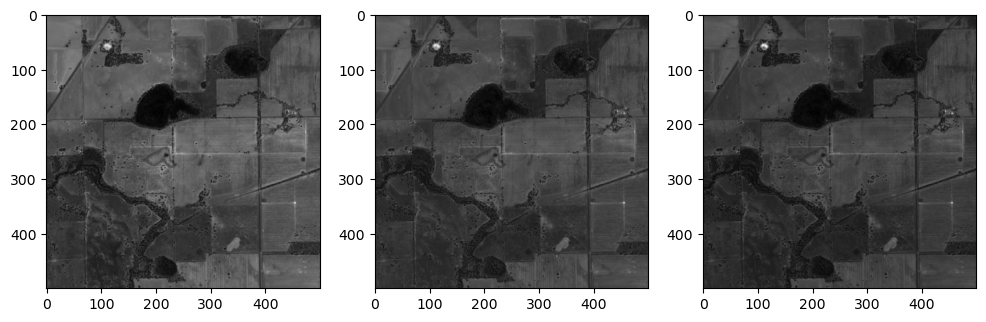

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12, 4))
ax1.imshow(red, cmap='gray')
ax2.imshow(green, cmap='gray')
ax3.imshow(blue, cmap='gray')

Using `Numpy` we can stack the previous arrays and use `Matplotlib` to plot a color image, but first we need to normalize their values:

In [ ]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

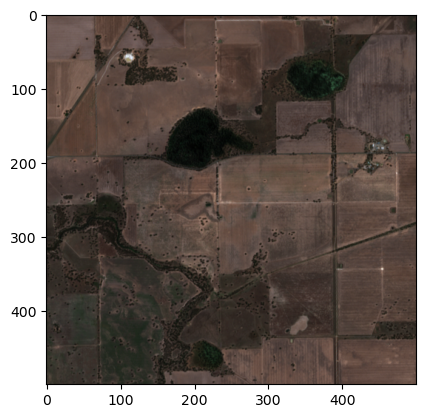

In [ ]:
rgb = numpy.dstack((normalize(red), normalize(green), normalize(blue)))
plt.imshow(rgb)
plt.savefig('rgb.png')

# References
- [Spatio Temporal Asset Catalog Specification](https://stacspec.org/)

- [Python Client Library for STAC Service](https://pystac-client.readthedocs.io/en/latest/)

- [Image processing on images obtained through STAC](./stac-image-processing.ipynb)